In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from multiprocessing import Pool
from tqdm import tqdm

# Skewed Bernoulli map and its derivative
def f_SB(x, b):
    return np.where(x <= 1 / b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return np.where(x <= 1 / b, b, b / (b - 1))

# Generate sparse Erdos-Renyi graph with self-loops
def generate_sparse_adjacency_matrix(N, p):
    A = (np.random.rand(N, N) < p).astype(float)
    np.fill_diagonal(A, 1.0)
    return csr_matrix(A)

# Evolution step using sparse matrix A
def evolve_system_sparse(y, v, epsilon, b, A_sparse):
    N = len(y)
    degrees = np.array(A_sparse.sum(axis=1)).flatten()
    degrees_safe = np.where(degrees == 0, 1, degrees)
    self_weight = degrees / N

    term_self_y = (1 - epsilon) * y * self_weight
    term_neighbors_y = epsilon * A_sparse.dot(y) / degrees_safe
    input_y = term_self_y + term_neighbors_y
    y_next = f_SB(input_y, b)

    term_self_v = (1 - epsilon) * v * self_weight
    term_neighbors_v = epsilon * A_sparse.dot(v) / degrees_safe
    input_v = term_self_v + term_neighbors_v
    f_prime = df_SB(input_y, b)
    v_next = f_prime * input_v

    return y_next, v_next

# Compute LE with fixed sparse A (for multiprocessing)
def compute_lyapunov_fixed_A_sparse(args):
    y, v, epsilon, b, T_trans, T_lyap, A_sparse = args
    for _ in range(T_trans):
        y, v = evolve_system_sparse(y, v, epsilon, b, A_sparse)
        v /= np.linalg.norm(v)

    le_sum = 0.0
    for _ in range(T_lyap):
        y, v = evolve_system_sparse(y, v, epsilon, b, A_sparse)
        norm_v = np.linalg.norm(v)
        le_sum += np.log(norm_v)
        v /= norm_v

    return le_sum / T_lyap

# Averaging over trials using multiprocessing
def compute_lyapunov_avg_fixed_A_sparse(N, b, epsilon, T_trans, T_lyap, trials, p):
    A_sparse = generate_sparse_adjacency_matrix(N, p)
    args_list = [
        (
            np.random.rand(N).astype(np.float64),
            np.random.rand(N).astype(np.float64) / np.linalg.norm(np.random.rand(N)),
            epsilon, b, T_trans, T_lyap, A_sparse
        )
        for _ in range(trials)
    ]
    with Pool() as pool:
        le_list = list(tqdm(pool.imap(compute_lyapunov_fixed_A_sparse, args_list), total=trials, desc=f"Trials for N={N}"))
    return np.mean(le_list)

# R^2 score utility
def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

# Simulation and plotting function
def simulate_and_plot_fixed_A_sparse(N_list, b=4.0, epsilon=0.2, p=0.3, trials=3, T_trans=1000, T_lyap=2000):
    lambda_list = []
    for N in N_list:
        print(f"\n>>> Running N = {N} <<<")
        le = compute_lyapunov_avg_fixed_A_sparse(N, b, epsilon, T_trans, T_lyap, trials, p)
        lambda_list.append(le)

    lambda_array = np.array(lambda_list)
    lambda_inf = np.mean(lambda_array[-3:])

    # Plotting
    plt.figure(figsize=(12, 5))

    # λ(N) vs 1/ln(N)
    plt.subplot(1, 2, 1)
    x1 = 1 / np.log(N_list)
    y1 = lambda_array
    coeffs1 = np.polyfit(x1, y1, 1)
    y1_fit = np.polyval(coeffs1, x1)
    r2_1 = r2_score(y1, y1_fit)
    plt.plot(x1, y1, 'bo', label='Data')
    plt.plot(x1, y1_fit, 'g--', label='Fit')
    plt.xlabel('1 / ln(N)')
    plt.ylabel('λ(N)')
    plt.title(f'Logarithmic Fit\n$R^2$ = {r2_1:.4f}')
    plt.legend()

    # ln(λ∞ - λ(N)) vs ln(N)
    plt.subplot(1, 2, 2)
    x2 = np.log(N_list)
    delta = np.abs(lambda_inf - lambda_array) + 1e-12
    y2 = np.log(delta)
    coeffs2 = np.polyfit(x2, y2, 1)
    y2_fit = np.polyval(coeffs2, x2)
    r2_2 = r2_score(y2, y2_fit)
    gamma = -coeffs2[0]
    plt.plot(x2, y2, 'bo', label='Data')
    plt.plot(x2, y2_fit, 'g--', label='Fit')
    plt.xlabel('ln(N)')
    plt.ylabel('ln(λ∞ - λ(N))')
    plt.title(f'Power-law Fit, γ ≈ {gamma:.2f}\n$R^2$ = {r2_2:.4f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return lambda_array, gamma, r2_1, r2_2

# Example usage (uncomment to run)
# N_list = [400, 800, 1600, 3200, 6400]
# lambda_vals, gamma, R2_log, R2_power = simulate_and_plot_fixed_A_sparse(N_list, epsilon=0.2, p=0.3)




>>> Running N = 400 <<<


Trials for N=400: 100%|██████████| 3/3 [00:04<00:00,  1.36s/it]


>>> Running N = 800 <<<



Trials for N=800: 100%|██████████| 3/3 [00:07<00:00,  2.37s/it]


>>> Running N = 1600 <<<



Trials for N=1600: 100%|██████████| 3/3 [00:23<00:00,  7.86s/it]



>>> Running N = 3200 <<<


Trials for N=3200: 100%|██████████| 3/3 [01:38<00:00, 32.94s/it]



>>> Running N = 6400 <<<


Trials for N=6400: 100%|██████████| 3/3 [06:21<00:00, 127.09s/it]



>>> Running N = 12800 <<<


Trials for N=12800: 100%|██████████| 3/3 [29:21<00:00, 587.27s/it]


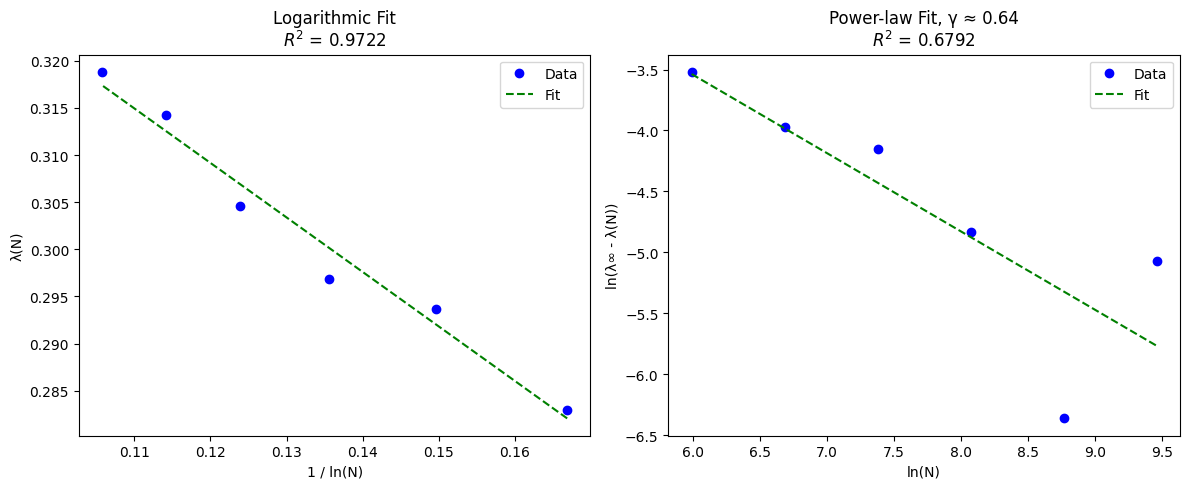

In [ ]:
N_list = [400, 800, 1600, 3200, 6400, 12800]
lambda_vals, gamma, R2_log, R2_power = simulate_and_plot_fixed_A_sparse(N_list, epsilon=0.2, p=0.3)

In [ ]:
print(lambda_vals)
print(gamma)
print(R2_log)
print(R2_power)

[0.28295526 0.29371703 0.2968601  0.30456773 0.3142821  0.3188211 ]
0.6435400257164997
0.9721638112691673
0.6792452914999971



>>> Running N = 25600 <<<


Trials for N=25600: 100%|██████████| 3/3 [1:46:16<00:00, 2125.43s/it]
/tmp/ipython-input-1-717671865.py:95: RankWarning: Polyfit may be poorly conditioned
  coeffs1 = np.polyfit(x1, y1, 1)
/tmp/ipython-input-1-717671865.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - ss_res / ss_tot
/tmp/ipython-input-1-717671865.py:110: RankWarning: Polyfit may be poorly conditioned
  coeffs2 = np.polyfit(x2, y2, 1)
/tmp/ipython-input-1-717671865.py:75: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - ss_res / ss_tot


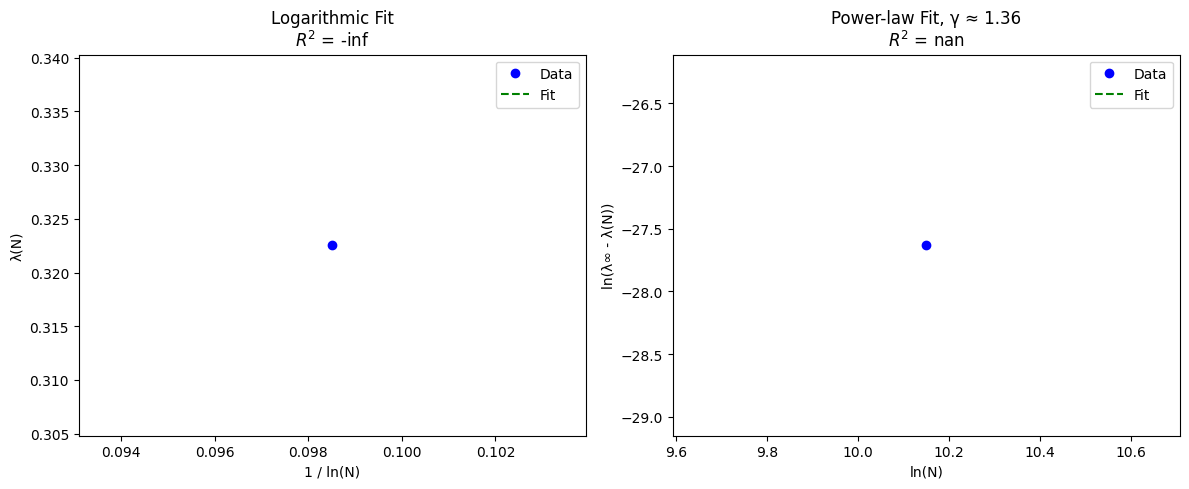

In [ ]:
ls = [25600]
a,b,c, d = simulate_and_plot_fixed_A_sparse(ls, epsilon=0.2, p=0.3)